<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Hawkes process simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.stats import ks_2samp, kstest

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import simulate_hawkes, simulate_hawkes_ogata

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

### Hawkes process simulation

In [2]:
mu = 3

def g0_const(t, mu=mu):
    return mu * np.ones_like(t)

def g0_bar_const(t, mu=mu):
    return mu * t

2.147342548061669 1.1929680822564828


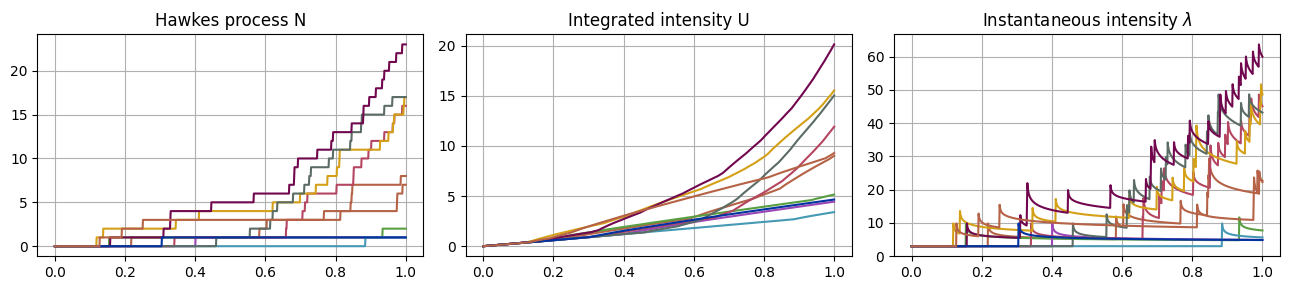

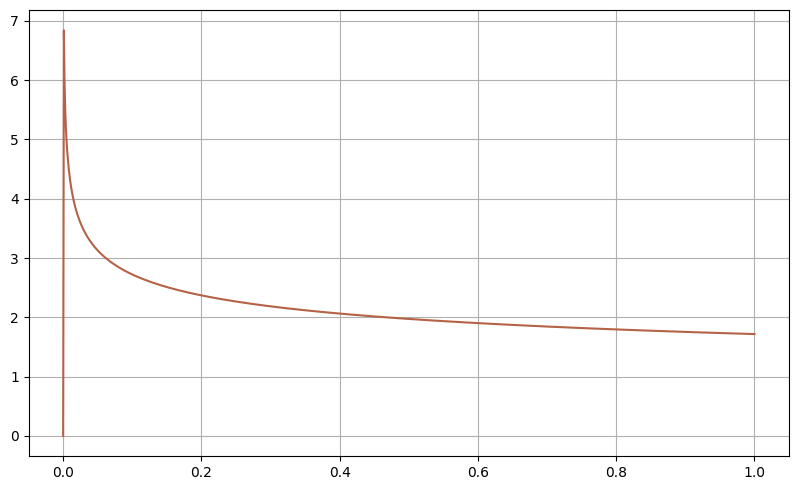

In [3]:
H = 0.3
lam = 1
c = 2
alpha = 2

T = 1
n_steps = 1000
n_paths = 10

t_grid = np.linspace(0, T, n_steps + 1)

rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)
ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const)
N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)

print(K.integrated_kernel(T), K.double_integrated_kernel(T) / T)

fig, ax = plt.subplots(1, 3, figsize=(13, 3))
n_show = n_paths

ax[0].plot(t_grid, N[:, 0:n_show])
ax[0].set_title('Hawkes process N')
ax[0].grid("on")

#ax[1].plot(t_grid, U[:,0:n_show])
ax[1].plot(t_grid, U[:,0:n_show])
ax[1].set_title('Integrated intensity U')
ax[1].grid("on")

#ax[2].plot(t_grid[1:], dU[:, 0:n_show] / np.diff(t_grid).reshape((-1, 1)))
ax[2].plot(t_grid, lam[:,0:n_show])
ax[2].set_title('Instantaneous intensity $\lambda$')
ax[2].grid("on")

plt.show()

plt.plot(t_grid, K(t_grid))

# Sanity check

To check the proposed simulation algorighm, we compute the empirical means over the simulated trajectories of $N$ and $U$.

Note that
$$
\mathbb{E}[N_t] = \mathbb{E}[U_t] =: m_t,  
$$
where $m$ satisfies the Fredholm's equation
$$
m_t = \bar g_0(t) + \int_0^tK(t - s)m_sds,
$$
and hence,
$$
m_t = \bar g_0(t) + \int_0^tR(t - s) g_0(s)ds,
$$
where $R$ is the resolvent of $K$ satisfying
$$
R * K = K * R = R - K.
$$

For instance, the resolvent corresponding to the fractional kernel is given by
$$
R(t) = t^{\alpha - 1} E_{\alpha, \alpha}(t^\alpha), \quad \alpha = H + 0.5,
$$
where $E_{\alpha, \beta}$ denotes the Mittag–Leffler function
$$
E_{\alpha, \beta}(z) = \sum_{n \geq 0}\dfrac{z^n}{\Gamma(\alpha n + \beta)}.
$$

In [ ]:
rng = np.random.default_rng(seed=42)
n_show = 100
n_paths = 10000

ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
ivi_hawkes_res = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar_res, g0_bar_res=e.g0_bar_res, rng=rng, g0=e.g0, resolvent_flag=True)

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)

expected_U = ivi_hawkes.U_mean(t_grid=e.t_grid)

hawkes_arrivals_sample = [simulate_hawkes(T=e.T, g0=e.g0, g0_upper_bound=e.mu, kernel=e.kernel, rng=rng) for _ in range(n_paths)]
N_T_sample = np.array([len(hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
U_sample = np.array([U_from_jumps(e.t_grid, hawkes_arrivals, e.kernel, e.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
expected_U_mc = np.mean(U_sample, axis = 0)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(e.t_grid, N[:, 0:n_show])
ax[0, 0].plot(e.t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(e.t_grid, U[:,0:n_show])
ax[0, 1].plot(e.t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].legend()
ax[0, 1].grid("on")

# ax[1, 0].plot(e.t_grid, N_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 0].plot(e.t_grid, N.mean(axis=1), "r", label="MC (iVi)")
ax[1, 0].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process N')
ax[1, 0].legend()
ax[1, 0].grid("on")

# ax[1, 1].plot(e.t_grid, U_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 1].plot(e.t_grid, U.mean(axis=1), "r", label="MC (iVi)")
ax[1, 1].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
# ax[1, 1].plot(e.t_grid, expected_U_mc, label = "MC (exact)")
ax[1, 1].set_title('Integrated intensity U')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.savefig("Hawkes_mean.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

0.0030142991907230734
0.0030027027493614313
0.002997802255317182
0.0029948575075617995
0.0029914744239657805
0.002993332172236763
0.0029926727191562173
0.0029891941861704603
0.0029790199315963464
0.0029858236440290986
0.002984034611157144
0.0029859646817253977
0.0029865588069566767
0.0029858507288532572
0.002983209187161632
0.0029797371948201675
0.002981888781378178
0.0029776816063246947
0.0029798506525615586
0.002983767513547882
0.002979952265774202
0.0029803371715374657
0.002977602325163977
0.002972718813410587
0.0029762763754634055
0.002975083884106304
0.002974000653091916
0.00297239323130194
0.0029714060485521838
0.0029698628139157024
0.0029699170741268504
0.002968786926837192
0.0029743754318667243
0.0029677768361884424
0.0029689513439009425
0.0029733052055613304
0.0029718815360056904
0.002970369133269517
0.002970650401905333
0.002969070243395458
0.002969414444088214
0.002966230641882934
0.0029619070780860495
0.002960199791993935
0.002963524541784947
0.002961695605641676
0.00296177

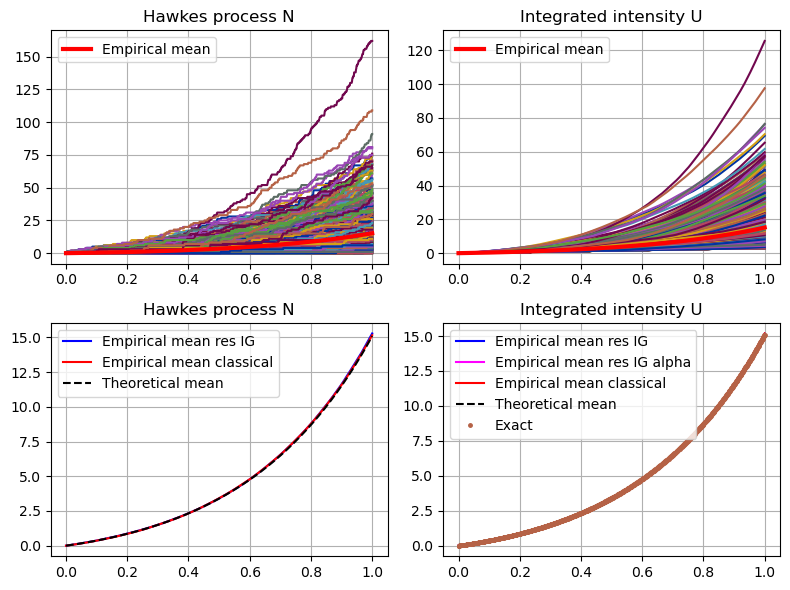

In [6]:
rng = np.random.default_rng(seed=42)

g0_bar_res = lambda t : mu * t + mu * K.resolvent.double_integrated_kernel(t)

res_IG = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const, trapeze=False, resolvent_IG=True, resolvent_alpha=False)
#res_IG_trapeze = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_res, rng=rng, g0=g0_const, trapeze=True, resolvent_IG=True, resolvent_alpha=False)
res_IG_alpha = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_res, rng=rng, g0=g0_const, trapeze=False, resolvent_IG=True, resolvent_alpha=True)
#ivi_hawkes_trapeze = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const, trapeze=True, resolvent = False)
ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const)


n_show = 1000
n_paths = 10000

N_res_IG, U_res_IG, lam = res_IG.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
#N_res_IG_trapeze, U_res_IG_trapeze, lam = res_IG_trapeze.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
N_res_IG_alpha, U_res_IG_alpha, lam = res_IG_alpha.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
#N_res, U_res, lam = ivi_hawkes_res.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)

ivi_hawkes_exact = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const, trapeze=False, resolvent_IG = False, resolvent_alpha=False)
expected_U = ivi_hawkes_exact.U_mean(t_grid=t_grid)

hawkes_arrivals_sample = [simulate_hawkes(T=T, g0=lambda t : g0_const(t, mu=mu), g0_upper_bound=mu, kernel=K, rng=rng)
                          for _ in range(n_paths)]
N_T_sample = np.array([len(hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
U_sample = np.array([ivi_hawkes_exact.U_from_jumps(np.array(t_grid), hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(t_grid, N[:, 0:n_show])
ax[0, 0].plot(t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(t_grid, U[:,0:n_show])
ax[0, 1].plot(t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].legend()
ax[0, 1].grid("on")

ax[1, 0].plot(t_grid, N_res_IG.mean(axis=1), "b", label="Empirical mean res IG")
ax[1, 0].plot(t_grid, N.mean(axis=1), "r", label="Empirical mean classical")
ax[1, 0].plot(t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process N')
ax[1, 0].legend()
ax[1, 0].grid("on")

ax[1, 1].plot(t_grid, U_res_IG.mean(axis=1), "b", label="Empirical mean res IG")
#ax[1, 1].plot(t_grid, U_res_IG_trapeze.mean(axis=1), "g", label="Empirical mean res IG trapeze")
ax[1, 1].plot(t_grid, U_res_IG_alpha.mean(axis=1), "magenta", label="Empirical mean res IG alpha")
ax[1, 1].plot(t_grid, U.mean(axis=1), "r", label="Empirical mean classical")
ax[1, 1].plot(t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 1].plot(t_grid, np.mean(U_sample, axis = 0), label = "Exact", linestyle = ' ', marker = '.', ms = 5)
ax[1, 1].set_title('Integrated intensity U')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.show()

## Simulation of the jump moments

In [35]:
H = 0.3
lam = 1.1
c = 1
alpha = 2.5

T = 10
n_steps = 100
n_paths = 1

t_grid = np.linspace(0, T, n_steps + 1)

rng = np.random.default_rng(seed = 42)


# K = FractionalKernel(H=H, c=c)
K = ExponentialKernel(lam=lam, c=c)
# K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)

ivi_hawkes_res = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_res, rng=rng, g0=g0_const, trapeze=False, resolvent_IG=True)
ivi_hawkes = IVIHawkesProcess(kernel=K, g0_bar=g0_bar_const, rng=rng, g0=g0_const, trapeze=False, resolvent_IG=False)

In [36]:
%%time
t_grid = np.linspace(0, T, n_steps + 1)
N_jumps = ivi_hawkes.simulate_arrivals(t_grid=t_grid, n_paths=n_paths)
N_jumps_res = ivi_hawkes_res.simulate_arrivals(t_grid=t_grid, n_paths=n_paths)
N_jumps[0].shape

Wall time: 16.8 ms


(187,)

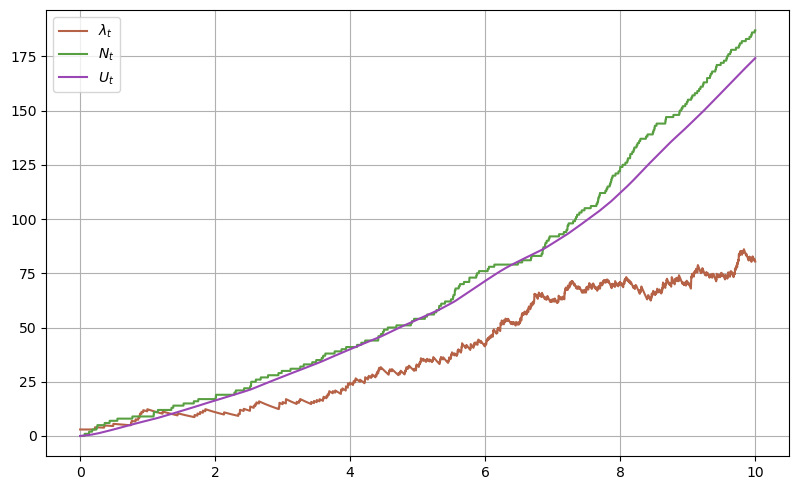

In [38]:
idx = 0

t_grid_fine = np.linspace(0, T, 10**4)
plt.plot(t_grid_fine, ivi_hawkes_res.lam_from_jumps(t_grid_fine, N_jumps_res[idx]), label="$\lambda_t$")
plt.plot(t_grid_fine, ivi_hawkes.N_from_jumps(t_grid_fine, N_jumps[idx]), label="$N_t$")
plt.plot(t_grid_fine, ivi_hawkes.U_from_jumps(t_grid_fine, N_jumps[idx]), label="$U_t$")
# plt.plot(t_grid_fine, ivi_hawkes.lam_from_jumps(t_grid_fine, N_jumps[idx]), label="$\lambda_t$")
plt.legend()

In [39]:
from scipy.stats import expon
import statsmodels.api as sm

def poisson_jumps_test(jumps):
    data = np.diff(jumps, prepend=0)
    data_unif = 1 - np.exp(-data)

    # Compute theoretical quantiles (from an Exponential(1) distribution)
    n = len(data)
    empirical_quantiles = np.sort(data)
    theoretical_quantiles = expon.ppf((np.arange(1, n+1) - 0.5) / n, scale=1.0)  # Inverse CDF (percent-point function)

    # Q-Q plot
    fig, ax =  plt.subplots(2, 2, figsize=(9, 8))
    ax[0, 0].scatter(theoretical_quantiles, empirical_quantiles, label="Observed vs. Exponential", s=10)
    ax[0, 0].plot(theoretical_quantiles, theoretical_quantiles, c=color_cycle[1], linestyle="dashed", label="y = x")

    ax[0, 0].set_xlabel("Theoretical Quantiles (Exponential)")
    ax[0, 0].set_ylabel("Empirical Quantiles (Data)")
    ax[0, 0].set_title("Q-Q Plot Against Exponential Distribution")
    ax[0, 0].legend()

    ax[0, 1].scatter(data_unif[:-1], data_unif[1:], s=10)
    ax[0, 1].set_title(r"$(e^{-\tau_i}, e^{-\tau_{i+1}})$")
        
    x_grid = np.linspace(data.min(), data.max(), num=1000)
    ecdf = sm.distributions.ECDF(data)
    ax[1, 0].plot(x_grid, ecdf(x_grid), label="ECDF")
    ax[1, 0].plot(x_grid, 1 - np.exp(-x_grid), "--", label="Exact CDF")
    ax[1, 0].set_title("Empirical CDF")
    ax[1, 0].legend()

    x_grid = np.linspace(0, np.max(data), 1000)
    ax[1, 1].hist(data, bins=20, density=True, alpha=0.4)
    ax[1, 1].plot(x_grid, np.exp(-x_grid), label="PDF")
    ax[1, 1].set_title("Histogram")
    ax[1, 1].legend()

    print("Kolmogorov-Smirnov test p-value: ", kstest(rvs=data, cdf=lambda x: 1 - np.exp(-x)).pvalue)
    
    plt.show()

Kolmogorov-Smirnov test p-value:  0.5539845291259968


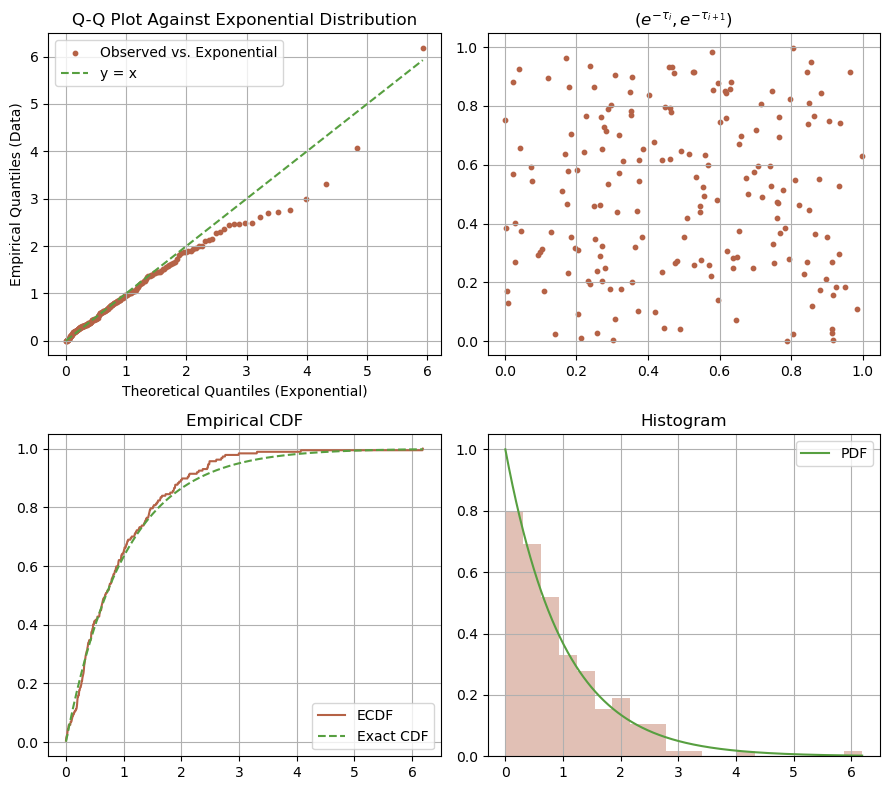

Kolmogorov-Smirnov test p-value:  0.0002851177236622356


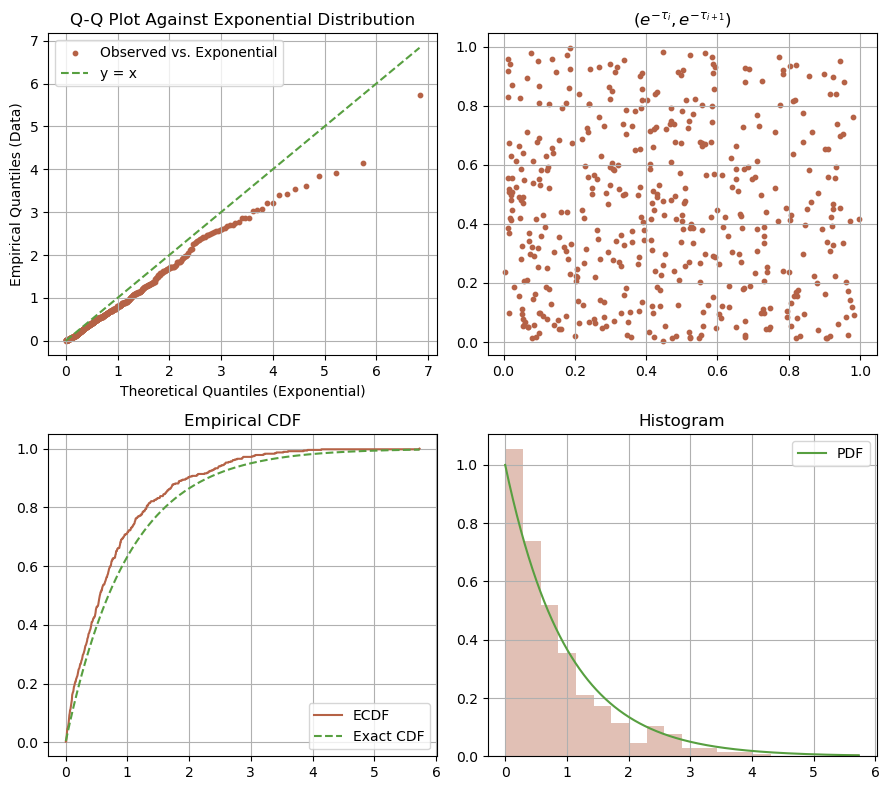

In [41]:
poisson_jumps_test(ivi_hawkes.U_from_jumps(N_jumps[idx], N_jumps[idx]))
poisson_jumps_test(ivi_hawkes.U_from_jumps(N_jumps_res[idx], N_jumps_res[idx]))